In [1]:
import pickle
import cv2
import numpy as np
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
#from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
EPOCHS=30
INIT_LR=1e-3
BS=64
default_image_size = tuple((128,128))
image_size = 128
directory_root = '/content/drive/MyDrive/Colab Notebooks/Ginger_Image_Data'
width=128
height=128
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (128,128))   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Healthy ...
[INFO] Processing Bacterial_Wilt ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)

In [6]:
print (image_size)

4618


In [7]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
#pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
print(label_binarizer.classes_)

['Bacterial_Wilt' 'Healthy']


In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [10]:
np_image_list.shape

(4618, 128, 128, 3)

In [11]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 41) 

[INFO] Spliting data to train, test


In [12]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [13]:
model = Sequential()
model.add(Conv2D(32, (5, 5),strides=2, input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=1))
model.add(Conv2D(32, (3, 3),strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=1))
model.add(Conv2D(128, (3, 3),strides=1))
model.add(Activation('relu'))
model.add(Conv2D(64, (5, 5),strides=2))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3),strides=1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        2432      
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 58, 58, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 57, 57, 32)       0         
 2D)                                                    

In [15]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,verbose=1
    )

<ipython-input-16-ab79dce86fd7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
57/57 [==============================] - 25s 279ms/step - loss: 0.6808 - accuracy: 0.5380 - val_loss: 1.0200 - val_accuracy: 0.4729
Epoch 2/30
57/57 [==============================] - 15s 261ms/step - loss: 0.4847 - accuracy: 0.7722 - val_loss: 0.3543 - val_accuracy: 0.8387
Epoch 3/30
57/57 [==============================] - 15s 265ms/step - loss: 0.3475 - accuracy: 0.8610 - val_loss: 0.2833 - val_accuracy: 0.9091
Epoch 4/30
57/57 [==============================] - 15s 260ms/step - loss: 0.3735 - accuracy: 0.8565 - val_loss: 0.3793 - val_accuracy: 0.8225
Epoch 5/30
57/57 [==============================] - 15s 268ms/step - loss: 0.3067 - accuracy: 0.8813 - val_loss: 0.3083 - val_accuracy: 0.8442
Epoch 6/30
57/57 [==============================] - 15s 260ms/step - loss: 0.2681 - accuracy: 0.9047 - val_loss: 0.3021 - val_accuracy: 0.8777
Epoch 7/30
57/57 [==============================] - 15s 258ms/step - loss: 0.2412 - accuracy: 0.9017 - val_loss: 0.2242 - val_accuracy: 0.8896

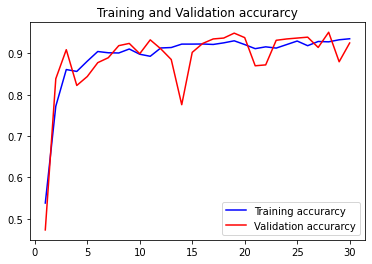

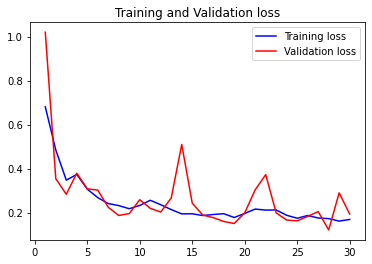

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [18]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
29/29 [==============================] - 0s 11ms/step - loss: 0.1935 - accuracy: 0.9253
Test Accuracy: 92.53246784210205


In [19]:
# save the model to disk
print("[INFO] Saving model...")
#pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...
